# Implementação da fase backward

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [2]:
def criaDatasetXOR(n=1000):
    X,y = make_blobs(n_samples=n,centers=[[0,0],[1,0],[1,1],[0,1]],cluster_std=0.1)
    y = np.array(y%2,dtype=int)
    return X,y

def plotDataSet(X,y):
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    for k in set(y):
        #print("k=",k)
        plt.plot(X[:,0][y==k],
                 X[:,1][y==k],
                 "o",alpha=0.3)

def plotDatasetRegressao(X, y):
    plt.plot(X[:,0], y, "o", alpha=0.3)

def plotHiperplano(X,y,vetor, intercept=0):
    x0min = min(X[:,0])
    x0max = max(X[:,0])
    
    xs = np.linspace(x0min, x0max, num=2)
    ys = (-vetor[0]/vetor[1])*xs-intercept/vetor[1]
    plt.plot(xs,ys)

def PlotCusto(custos):
    if (len(custos) == 0):
        print('ERRO: Modelo ainda não treinado para avaliar o custo!')
        return
    
    x = [i for i in range(1,len(custos) + 1)]

    plt.xlabel('Nº Iterações')
    plt.ylabel('Custo')
    plt.plot(x, custos, "-")
    plt.show()

In [3]:
def define_axes(X,margem=0.1):

    min1 = X[:,0].min()
    max1 = X[:,0].max() 

    min2 = X[:,1].min()
    max2 = X[:,1].max() 

    return [min1-margem, max1+margem, min2-margem, max2+margem] 

def plotPredictions(clf, X, margem=0.1):
    axes = define_axes(X, margem=margem)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0,x1 = np.meshgrid(x0s, x1s)
    X_ = np.c_[x0.ravel(), x1.ravel()] 
    ypred  = clf.predict(X_).reshape(x0.shape)
    plt.contourf(x0,x1,ypred,cmap=plt.cm.brg, alpha=0.2)

Criar uma base para o problema XOR, com apenas 4 exemplos e sem separação entre treino e teste.

In [4]:
X,y = criaDatasetXOR(n=4)

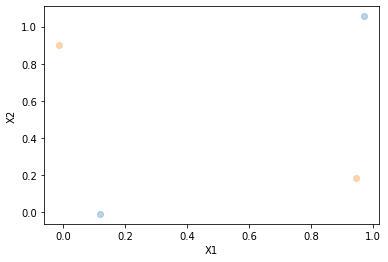

In [5]:
plotDataSet(X,y)

In [6]:
from scipy.special import expit
def tanh(a):
    return expit(a)*2-1

In [7]:
def includeBias(X):
    bias = np.ones((X.shape[0], 1))
    Xb = np.concatenate((bias, X), axis=1)
    return Xb

In [12]:
class BackPropagation():
    def __init__(self):
        self.n_hidden = 2
        self.activation = tanh
        self.learning_rate = 0.01
        self.max_iter = 10000
    
    def forward(self):
        self.pH = self.Xb @ self.wih
        self.H = self.activation(self.pH)
        self.Hb = includeBias(self.H)
        self.py = self.Hb @ self.who  

    def backward(self,y):
        ho_delta = y - self.py
        ho_grad = self.Hb.T @ ho_delta
        #PULO DO GATO
        tanh_grad = (1 - np.square(self.H))
        ih_delta = (ho_delta @ self.who[1:,:].T) * tanh_grad
        ih_grad = self.Xb.T @ ih_delta
        self.who += ho_grad*self.learning_rate
        self.wih += ih_grad*self.learning_rate

    def fit(self,X,y):
        self.Xb = includeBias(X)
        self.wih = np.random.uniform(-1,1,size=(self.Xb.shape[1],self.n_hidden))
        self.who = np.random.uniform(-1,1,size=(self.n_hidden+1,y.shape[1])) 
        for _ in range (self.max_iter):
            self.forward()
            self.backward(y)

    def predict(self,X):
        Xb = includeBias(X)
        H = self.activation(Xb@self.wih)
        Hb = includeBias(H)
        return Hb@self.who

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import label_binarize

class MLP(BaseEstimator, ClassifierMixin):
    def __init__(self, training_algorithm=BackPropagation()):
        self.training_algorithm = training_algorithm 

    def encode_labels(self,y):
        self.labels = list(set(y))
        return label_binarize(y,classes=self.labels)*2-1

    def fit(self,X,y):
        yhot = self.encode_labels(y)
        self.training_algorithm.fit(X,yhot)

    def predict(self,X,y=None):
        a = self.training_algorithm.predict(X)
        if len(self.labels) <= 2:
            idx = np.array(a>0,dtype=int).reshape(-1,)
        else:
            idx = np.argmax(a,axis=1)
        ypred = np.array([self.labels[i] for i in idx])
        return ypred

In [14]:
def accuracy(yactual, ypred):
    return sum(yactual == ypred)/len(yactual)

1.0


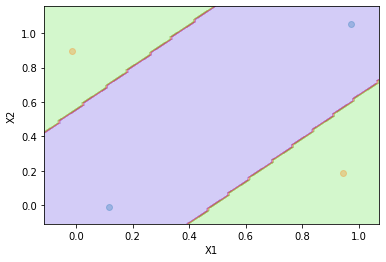

In [15]:
mlp = MLP()
mlp.fit(X, y)
print(accuracy(y, mlp.predict(X)))
plotDataSet(X, y)
plotPredictions(mlp, X)